# Decision Tree on Heart Disease Dataset
During this experiment, the decision tree and random forest algorithms will be implemented from scratch using PyTorch.<br>
The models will be trained using the Heart Disease Dataset:
https://archive.ics.uci.edu/ml/datasets/heart+Disease

The 14 features were selected among 76 attributes: 
1. age: age in years
2. sex:
    - 1: male
    - 0: female
3. cp: chest pain type
    - 0: asymptomatic
    - 1: atypical angina
    - 2: non-anginal pain
    - 3: typical angina
4. trestbps: resting blood pressure
5. chol: serum cholestoral in mg/dl
6. fbs: fasting blood sugar > 120 mg/dl
7. restecg: resting electrocardiographic results
    - 0: showing probable or definite left ventricular hypertrophy by Estes' criteria
    - 1: normal
    - 2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina 
10. oldpeak: ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
    - 1: upsloping
    - 2: flat
    - 3: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal:
    - 3 : fixed defect
    - 6 : normal
    - 7 : reversable defect
14. disease:
    - 0: artery diameter narrowing < 50%
    - 1-3: artery diameter narrowing > 50%, close to 3 is very severe

In [99]:
import os
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score

### Read csv using Pandas

In [100]:
hdisease = pd.read_csv(os.path.join('data', 'processed.cleveland.data'))

In [101]:
# The data does not include the columns names, we did a little trick to add them
columns = {
    '63.0' : 'age',
    '1.0' : 'sex',
    '1.0.1' : 'cp',
    '145.0' : 'trestbps',
    '233.0' : 'chol',
    '1.0.2' : 'fbs',
    '2.0' : 'restecg',
    '150.0' : 'thalach',
    '0.0' : 'exang',
    '2.3' : 'oldpeak',
    '3.0' : 'slope',
    '0.0.1' : 'ca',
    '6.0' : 'thal',
    '0' : 'disease'
}
hdisease.rename(columns=columns, inplace=True)

### Replacing missing values

In [102]:
# Remove the severity of the disease, 0: healthy, 1: sick
hdisease.loc[hdisease['disease'] > 1, 'disease'] = 1
# Setting missing values to unknown value
hdisease.loc[hdisease['ca'] == '?', 'ca'] = 4.0
hdisease.loc[hdisease['thal'] == '?', 'thal'] = 0.0
# Setting all values to float
hdisease = hdisease.astype(float)

In [103]:
hdisease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1.0
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0.0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0.0


### Correlation Heatmap

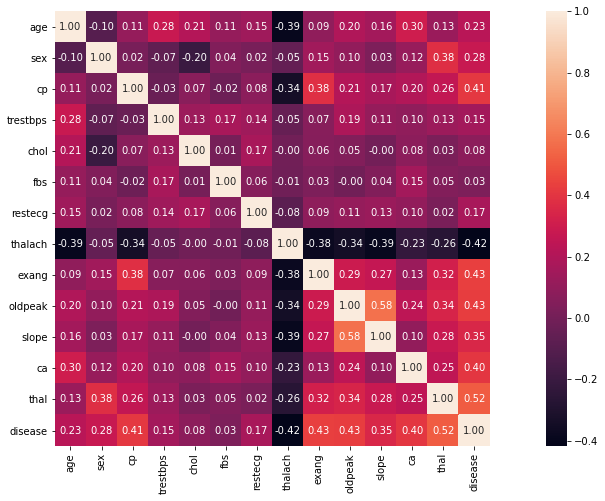

In [104]:
plt.figure(figsize=(20, 8))
sns.heatmap(hdisease.corr(), annot=True, square=True, fmt='0.2f')

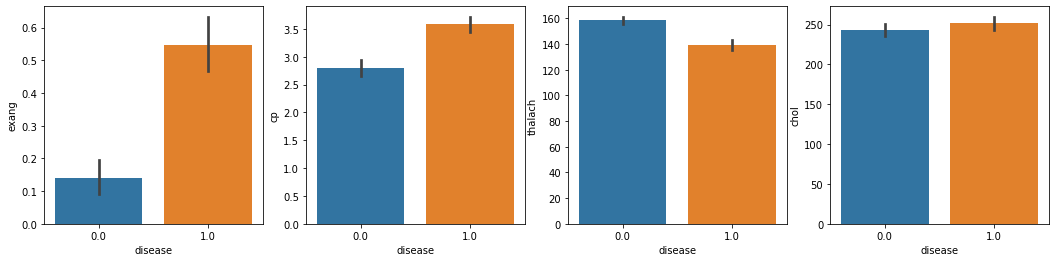

In [105]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 4))
sns.barplot(x='disease', y='exang', data=hdisease, ax=ax1)
sns.barplot(x='disease', y='cp', data=hdisease, ax=ax2)
sns.barplot(x='disease', y='thalach', data=hdisease, ax=ax3)
sns.barplot(x='disease', y='chol', data=hdisease, ax=ax4)

Most features are highly correlated to the disease column.
By interpreting the barplots of the healthy and sick patient groups, it is likely that a patient with heart disease will have the following caracteristics:
- cp: more chest pain
- thalach: a lower maximum heart rate. Surprisingly, high beats per minute is a signal of heart health
- exang: increase pain when exercising
- cholesterol levels are similar through sick and healthy patient: no direct link with heart disease

### Decision Trees
Decision trees are defined by recursively partitioning the input space into regions. Each region is partitioned into sub-regions for each child node.
Each leaf node maps the input to a class or regression value depending on the task. Space is sub-divided into non overlapping regions based on some criteria at each node. Once created, a tree can be navigated with a new sample of data following each branch with the splits until a final prediction is made.
To understand how to grow a tree, we must introduce the gini index first.
Assuming that $D$ is the data in a leaf and $N$ the number of samples in $D$, we estimate the class-conditional probability as follow:
$$
    \hat{\pi}_c = \frac{1}{N} \sum_{i \in D}\mathbb{I}(y_i = c)
$$
where $c$ are the classes of the target. The Gini index of a given leaf is:
$$
    G_{l} = \sum_{c=1}^{C}\hat{\pi}_c(1 -\hat{\pi}_c) = 1 - \sum_{c=1}^{C}\hat{\pi}^2_c
$$
To have the Gini index of a split, we compute the Gini index on each of its leaves and sum the indexes weighted by the number of samples in each leaf over the total number of samples to split:
$$
    G_{Node} = \sum_{i=1}^{K} \frac{k_{li}}{U}G_{li}
$$
where $K$ is the number of leaves of the node, $k_{li}$ is the number of samples in the leaf $i^{th}$ leaf and $U$ is the number of sample to split.
            
In the case of categorical inputs, the most common approach is to consider splits of the form $x_{ij} = c_k$ and $x_{ij} \neq c_k$, for each possible class label $c_k$.
The rule to perform a split on a node is as follow:
- if the node is in the maximum depth of the tree, keep it as a leaf.
- for each attribute, we try all the possible thresholds and compute the Gini index of each split. The threshold across all attributes that minimize the Gini index is selected
- a node is said pure if the split generates a empty leaf. If a node is pure, it is set as a leaf.
- if the node has a lowest score than the Gini index of the best split, we keep it as a leaf.
- if the Gini index of a leaf is lower than the Gini index of the potential split at this leaf, we will keep it as a a leaf node.

In [106]:
# Check which data are categorical or not
is_categorical = []
for col in hdisease.columns:
    # If less than 9 unique values, than the feature is categorical
    is_categorical.append(int(len(np.unique(hdisease[col])) < 9))
# Convert to Pytorch tensor
is_categorical = torch.tensor(is_categorical)[:-1]

In [107]:
# Convert data to numpy
data = hdisease.values
# Get unique values of the target
utarget = torch.from_numpy(np.unique(data[:, -1]))

### Convert data to Pytorch

In [108]:
X = torch.from_numpy(data[:, :-1])
y = torch.from_numpy(data[:, -1]).int()

### Gini index function

In [109]:
def gini(y):
    pi = (y.bincount() / float(y.shape[0]))
    return 1 - pi.pow(2).sum()

### Node class

In [110]:
# Base class of a node
class Node():
    def __init__(self, X, y, is_categorical, max_depth, columns, depth=0, nb_features=0):
        # If training random forest 
        if nb_features != 0:
            self.col_perm = torch.randperm(X.shape[1])[:nb_features]
            self.X = X[:, self.col_perm]
            self.X_full = X
            self.columns = columns[self.col_perm]
            self.col_full = columns
            # List of binary values defining if each feature is categorical or not
            self.is_categorical_list = is_categorical[self.col_perm]
            self.is_catfull = is_categorical
        else:
            self.X = X
            self.columns = columns
            self.is_categorical_list = is_categorical
        self.y = y
        self.size = float(X.shape[0])
        # Prediction if the node will turn into a leaf, or split value
        self.cutoff = None
        # Column to check for splitting the data 
        self.col = None
        # Child nodes
        self.left = None
        self.right = None
        # Whether or not the split value is categorical
        self.depth = depth
        self.nb_features = nb_features
        # Only used if training AdaBoost
        # If the node contains only one label, it is set as a leaf
        if self.is_pure() or depth == max_depth or self.X.shape[0] == 1:
            # Select the predominant categorical value and set it as the prediction
            self.make_leaf()
            return
            
        # Computing the gini index on the population before the split
        gini_n = gini(y)
        params = self.find_best_split()
        
        gini_s = params[0]
        # If no improvement, make the node as a leaf
        if gini_s >= gini_n:
            self.make_leaf()
        else:
            self.make_split(params, max_depth)
    
    # Clean variables that are not usefull to predict
    def clean_attributes(self):
        self.X = None
        self.y = None
        if self.nb_features != 0:
            self.X_full = None
            self.col_full = None
            self.is_catfull = None
    
    # Pure if there is only one label in the population
    def is_pure(self):
        return len(self.y.unique()) == 1
    
    # Return the most present label as a prediction if the node turns to a leaf
    def get_label(self):
        return self.y.bincount().argmax().item()
    
    def make_leaf(self):
        self.cutoff = self.get_label()
        #import random
        #self.cutoff = random.randint(0, 100)
        self.clean_attributes()
    
    # Performs the split
    def make_split(self, params, max_depth):
        self.col = params[1]
        self.cutoff = params[2]
        self.var_categorical = self.is_categorical_list[self.col].item()
        # Recursively split by creating two instances of the Node class using the two groups
        if self.nb_features != 0:
            cols = self.col_full
            categorical_list = self.is_catfull
        else:
            cols = self.columns
            categorical_list = self.is_categorical_list
        self.left = Node(X=params[3][0],
                         y=params[3][1],
                         is_categorical=categorical_list,
                         max_depth=max_depth,
                         columns=cols,
                         depth=self.depth + 1,
                         nb_features=self.nb_features)
        self.right = Node(X=params[4][0],
                          y=params[4][1],
                          is_categorical=categorical_list,
                          max_depth=max_depth,
                          columns=cols,
                          depth=self.depth + 1,
                          nb_features=self.nb_features)
        self.clean_attributes()
   
    # Compute the gini index of the future split
    def gini_split(self, idx_g_1, idx_g_2, cutoff, feature_idx, best_params):
        g_1 = self.y[idx_g_1].squeeze(1)
        g_2 = self.y[idx_g_2].squeeze(1)
        gini_g1 = gini(g_1) * (float(g_1.shape[0]) / self.size) 
        gini_g2 = gini(g_2) * (float(g_2.shape[0]) / self.size)
        gini_split = (gini_g1 + gini_g2)
        if gini_split < best_params[0]:
            best_params[0] = gini_split.item()
            best_params[1] = feature_idx
            best_params[2] = cutoff.item()
            # If training a base learner of a random forest
            # pass the full data to child nodes
            if self.nb_features != 0:
                best_params[3] = [self.X_full[idx_g_1].squeeze(1), g_1]
                best_params[4] = [self.X_full[idx_g_2].squeeze(1), g_2]
            else:
                best_params[3] = [self.X[idx_g_1].squeeze(1), g_1]
                best_params[4] = [self.X[idx_g_2].squeeze(1), g_2]
        return best_params
    
    def find_best_split(self):
        # Create a parameter list to store the parameters of the best split
        # It contains:
        # 1: best gini index
        # 2: column index of the best split
        # 3: value of the best split
        # 4: left group [X, y], less than equal to #3 or belongs to the class #3 if categorical
        # 5: right group [X, y], greater than #3 or does not belong to the class #3
        best_params = [2, -1, -1, None, None]
        for i in range(self.X.shape[1]):
            vals = self.X[:, i]
            if self.is_categorical_list[i]:
                for cutoff in vals.unique():
                    idx_uv = (vals == cutoff).nonzero()
                    idx_uv_not = (vals != cutoff).nonzero()
                    best_params = self.gini_split(idx_uv, idx_uv_not, cutoff, i, best_params)
            else:
                for cutoff in vals.unique():
                    idx_leq = (vals <= cutoff).nonzero()
                    idx_ge = (vals > cutoff).nonzero()
                    best_params = self.gini_split(idx_leq, idx_ge, cutoff, i, best_params)
        return best_params
    
    # Used for printing the tree as a dict object
    def get_dict(self):
        node_dict = {}
        if self.left is None and self.right is None:
            node_dict['pred'] = self.cutoff
        else:
            node_dict['cutoff'] = self.cutoff
            node_dict['feature'] = self.columns[self.col]
            node_dict['categorical'] = self.var_categorical
            node_dict['left'] = self.left.get_dict()
            node_dict['right'] = self.right.get_dict()
        return node_dict
   
    # Follow the tree based on the conditions
    def predict(self, sample):
        if self.nb_features != 0:
            sample_in = sample[self.col_perm]
        else:
            sample_in = sample
            
        if self.left is None and self.right is None:
            return self.cutoff
        if self.var_categorical:
            if sample_in[self.col] == self.cutoff:
                return self.left.predict(sample)
            else:
                return self.right.predict(sample)
        else:
            if sample_in[self.col] <= self.cutoff:
                return self.left.predict(sample)
            else:
                return self.right.predict(sample)

### Decision Tree Class

In [111]:
# Class that implements the sklearn methods
# Just a wrapper for our node class
class DecisionTreeClassifier(BaseEstimator):
    def __init__(self, max_depth, is_categorical, columns, nb_features=0):
        if nb_features < 0:
            raise ValueError('negative integer passed to nb_features.')
        self.max_depth = max_depth
        # Wether or not each column is a categorical value
        self.is_categorical = is_categorical
        self.columns = columns
        self.root = None
        # Number of random features to select
        # Only used when building a random forest base learner
        # If 0 then train a decision tree using all the features availables
        self.nb_features = nb_features
    
    def fit(self, X, y, **kwargs):
        # Just some trick to fit the sklearn requirements for using cross validation
        if self.nb_features > X.shape[1]:
            raise ValueError('parameter np_features should be less than equal to the number of features')
        self.root = Node(X, y, self.is_categorical, self.max_depth, self.columns, 0, self.nb_features)
        
    def predict(self, X):
        if len(X.shape) == 0:
            return 'error: can not predict on empty input.'
        if len(X.shape) == 1:
            return self.root.predict(X)
        
        pred = torch.zeros((X.shape[0],), dtype=torch.int32)
        if self.root == None:
            return 'error: use the fit method before using predict.'
        for i in range(X.shape[0]):
            sample = X[i, :]
            pred[i] = self.root.predict(sample)
        return pred
    
    #def get_params(self, deep=False):
    #    return {'max_depth' : self.max_depth,
    #            'is_categorical': self.is_categorical,
    #            'columns': self.columns,
    #            'nb_features' : self.nb_features}
    
    def __str__(self):
        if self.root == None:
            return 'error: use the fit method to print the result of the training.'
        tree_dict = self.root.get_dict()
        pprint(tree_dict)
        return ''

In [112]:
dt = DecisionTreeClassifier(max_depth=3,
                            is_categorical=is_categorical,
                            columns=hdisease.columns,
                            nb_features=13)
dt.fit(X, y)
print(dt)

{'categorical': 1,
 'cutoff': 3.0,
 'feature': 'thal',
 'left': {'categorical': 1,
          'cutoff': 0.0,
          'feature': 'ca',
          'left': {'categorical': 0,
                   'cutoff': 156.0,
                   'feature': 'trestbps',
                   'left': {'pred': 0},
                   'right': {'pred': 1}},
          'right': {'categorical': 1,
                    'cutoff': 4.0,
                    'feature': 'cp',
                    'left': {'pred': 1},
                    'right': {'pred': 0}}},
 'right': {'categorical': 1,
           'cutoff': 4.0,
           'feature': 'cp',
           'left': {'categorical': 0,
                    'cutoff': 0.5,
                    'feature': 'oldpeak',
                    'left': {'pred': 1},
                    'right': {'pred': 1}},
           'right': {'categorical': 1,
                     'cutoff': 0.0,
                     'feature': 'ca',
                     'left': {'pred': 0},
                     'right': {'pred

We just fit the whole data to the model to visualize the structure of the tree.<br>
In the next section, we will validate the performance of the model using cross validation and have an interpretation of the tree structure.

### Cross Validation

In [113]:
dt = DecisionTreeClassifier(max_depth=3,
                            is_categorical=is_categorical,
                            columns=hdisease.columns,
                            nb_features=13)
# Using 5 K-folds
test_acc = cross_val_score(dt, X, y, scoring='accuracy', cv=5).mean()
print('Accuracy on the test set:', test_acc)

Accuracy on the test set: 0.8110382513661202


Using cross validation and accuracy as our metric, the best model performed well for such simple classifier.
Indeed, 81% accuracy on a 5 k-fold cross validation is acceptable given the complexity of predicting heart disease.
Looking at the tree structure, the first split is done on the 'thal' feature which has the highest correlation with the target.
The most discriminative features are then 'ca', 'cp' and 'oldpeak' and they all have more than 40% correlation with the target.
The model uses the lower correlated variable such as 'chol' and 'testbps' inside the deeper nodes.

The 'thal' feature contributes the most in the decision. It refers to the Thalium stress test result, consisting in injecting radioactive element into the bloodstream of the patient. The 'thal' categorical values refers to the quality of blood circulation. It makes sense that a patient with poor blood circulation is very likely to have a heart disease.

The performance using a decision tree is acceptable, but let's try to do better using a Random Forest.

### Random Forest
Random forest is a technique known as bootstrap aggregating (bagging) which consists in taking multiple different models and compute the ensemble prediction:
$$
    f(\boldsymbol{x}) = \sum_{i = 0}^{M}f_m(\boldsymbol{x})
$$<br>
where $f_m$ is the $m^{th}$ model.<br>
The random forest technique is the ensemble model making use of decision trees. This ensemble model tries to decorrelate the base
learners by learning trees based on a randomly chosen subset of features, as well as a randomly chosen subset of data samples.

In other words, to train a random forest, we create $m$ subsets of the training set where we can select multiple times the same samples. These subsets are known as boostrapped datasets. Finally, each base learner is trained in the same fashion as a decision tree except that at each node, when we perform the split, we randomly choose a fixed number of features from the data.

In [114]:
class RandomForestClassifier(BaseEstimator):
    def __init__(self, max_depth, is_categorical, columns, nb_features, n_estimators):
        self.max_depth = max_depth
        self.is_categorical = is_categorical
        self.columns = columns
        self.nb_features = nb_features
        self.n_estimators = n_estimators
        self.trees = []
        
    def fit(self, X, y, **kwargs):
        if self.nb_features > X.shape[1]:
            raise ValueError('parameter np_features should be less than equal to the number of features') 
        for i in range(self.n_estimators):
            X_bstrp, y_bstrp = self.get_boostrap_data(X, y)
            dt = DecisionTreeClassifier(self.max_depth, self.is_categorical, self.columns, self.nb_features)
            dt.fit(X_bstrp, y_bstrp)
            self.trees.append(dt)
        
    def get_boostrap_data(self, X, y):
        idx = torch.randint(0, X.shape[0] - 1, size=(X.shape[0],))
        return X[idx, :], y[idx]
   
    def predict_sample(self, X):
        preds = np.array([0, 0])
        for tree in self.trees:
            preds[tree.predict(X)] += 1
        return preds.argmax() 

    def predict(self, X):
        if len(X.shape) == 0:
            return 'error: can not predict on empty input.'
        if len(X.shape) == 1:
            return self.predict_sample(X)
        
        pred = torch.zeros((X.shape[0],), dtype=torch.int32)
        if len(self.trees) == 0:
            return 'error: use the fit method before using predict.'
        for i in range(X.shape[0]):
            sample = X[i, :]
            pred[i] = self.predict_sample(sample)
        return pred
    #def predict(self, X):
    #    return torch.ones((X.shape[0],))

In [115]:
max_depth_params = [3, 4]
nb_features_params = [i for i in range(2, 10)]
for _ in range(20):
    max_depth = np.random.choice(max_depth_params)
    nb_features = np.random.choice(nb_features_params) 
    rf = RandomForestClassifier(max_depth=max_depth,
                                is_categorical=is_categorical,
                                columns=hdisease.columns,
                                nb_features=nb_features,
                                n_estimators=100)
    # Using 5 K-folds
    test_acc = cross_val_score(rf, X, y, scoring='accuracy', cv=5).mean()
    print('Test accuracy:\t' + str(test_acc) + ', nb features:\t' + str(nb_features) + ', max depth:\t', str(max_depth))

KeyboardInterrupt: 

After a quick parameter search, the model achieves 84% accuracy. A great improvement of 3% comparing to a single decision tree.<br>
To go further we will try a technique known as boosting.

### Boosting
Boosting is an algorithm using multiple weak learners. A weak learner is defined to be slightly better than random guessing. The purpose of boosting is to sequentially apply the weak classification algorithm to repeatedly modified versions of the data.
            
The most common weak learner is known as a  stamp. A stamp is an univariate tree with only one split.
The predictions from the weak learners are combined through a weighted majority vote:
$$
    f(\boldsymbol{x}) = \text{sign}\left(\sum_{m=1}^{M}\alpha_m f_m(\boldsymbol{x})\right)
$$
where $f(\boldsymbol{x})$ is the prediction of the final model, $f_m(\boldsymbol{x})$ is the prediction of the weak learner $m$ and $\{\alpha_1, \dots, \alpha_M\}$ are the weights computed by the boosting algorithm. Their effect is to give higher influence to the more accurate 
learners. This formula represent the prediction in case of a binary classification $\{-1, 1\}$
            
The data modification consists of applying weights $\{\boldsymbol{w_1}, \dots, \boldsymbol{w_m}\}$ to each training samples. Initially the weights are set to $\frac{1}{N}$ where $N$ is the number of samples. at iteration $k$, we perform a data transformation using the weights on each training samples. We fit the data into the model and the samples that were misclassified by the learner $f_{k-1}$ have their weights increased while the samples that were well classified by $f_{k-1}$ have their weights decreased. While the training goes on, the importance of the harder samples sequentially increase and the learners are forced to concentrate on the observation that are missed on the previous iterations.

In [182]:
class AdaBoostClassifier(BaseEstimator):
    def __init__(self, columns, is_categorical, n_estimators, lr=1):
        self.columns = columns
        self.is_categorical = is_categorical
        self.n_estimators = n_estimators
        self.lr = lr
        self.learners = []
        self.alphas = None
        for i in range(self.n_estimators):
            # Each learner is a stamp:
            # it has only split and is using only one feature
            self.learners.append(DecisionTreeClassifier(max_depth=1,
                                                        is_categorical=is_categorical,
                                                        columns=columns,
                                                        nb_features=0))
    
    def compute_weighted_err(self, y_true, y_pred, weights):
        idx_neq = (y_true != y_pred).nonzero()
        return weights[idx_neq].sum() / weights.sum()
    
    def set_alpha(self, err):
        if err == 0:
            return torch.log(1 / 1e-10) / 2
        return torch.log((1 - err) / err) / 2
    
    def update_weights(self, weights, y_true, y_pred, alpha, idx):
        old_weights = weights.clone()
        weights[idx] *= torch.exp(alpha * (y_pred != y_true).int().unsqueeze(1))
        weights[idx] *= torch.exp(-alpha * (y_pred == y_true).int().unsqueeze(1))
        weights /= weights.sum()
        return weights
    
    def update_range_select(self, weights, range_selection):
        range_selection[0, 0] = 0
        range_selection[0, 1] = weights[0]
        for i in range(1, weights.shape[0]):
            range_selection[i, 0] = range_selection[i - 1, 1]
            range_selection[i, 1] = range_selection[i, 0] + weights[i]
        return range_selection
            
    def rand_data_idx(self, size, range_selection, idx):
        rand_vals = torch.rand((size,))
        for i in range(size):
            r = rand_vals[i]
            for j in range(size):
                if r >= range_selection[j, 0] and r < range_selection[j, 1]:
                    idx[i] = j
                    break
        return idx
    
    def fit(self, X, y, **kwargs):
        size = X.shape[0]
        weights = torch.empty((size, 1)).fill_(1 / size)
        alphas = torch.zeros((self.n_estimators, 1))
        range_selection = torch.zeros((size, 2), dtype=torch.float32)
        idx = torch.tensor([i for i in range(size)])
        for i in range(self.n_estimators):
            X_cur = X[idx]
            y_cur = y[idx]
            weights_cur = weights[idx]
            
            self.learners[i].fit(X_cur, y_cur)
            pred = self.learners[i].predict(X_cur)
            err = self.compute_weighted_err(y_cur, pred, weights_cur)
            new_alpha = self.set_alpha(err)
            alphas[i] = new_alpha
                
            weights = self.update_weights(weights, y_cur, pred, new_alpha, idx)
            
            range_selection = self.update_range_select(weights, range_selection)
            idx = self.rand_data_idx(size, range_selection, idx)
            print(len(idx.unique()), end='\n\n')
        self.alphas = alphas
    
    def predict(self, X):
        size = X.shape[0]
        preds = torch.zeros((size, 1), dtype=torch.float32)
        for i in range(self.n_estimators):
            pred = self.learners[i].predict(X).unsqueeze(1)
            pred[pred == 0] = -1
            preds += self.alphas[i] * pred
        preds = torch.sign(preds)
        preds[preds == -1] = 0
        
        return preds
    
    #def predict(self, X):
    #    size = X.shape[0]
    #    preds = torch.zeros((size, 2), dtype=torch.float32)
    #    for i in range(self.n_estimators):
    #        pred = self.learners[i].predict(X)
    #        #print('alpha:', self.alphas[i])
    #        idx_z = (pred == 0).nonzero().squeeze(1)
    #        idx_nz = (pred == 1).nonzero().squeeze(1)
    #        preds[idx_z, 0] += self.alphas[i]
    #        preds[idx_nz, 1] += self.alphas[i]
    #        #print(np.c_[pred, preds], end='\n\n')
    #    return preds.argmax(dim=1)

In [187]:
adaboost = AdaBoostClassifier(hdisease.columns, is_categorical, n_estimators=10)
adaboost.fit(X, y)

171

166

168

156

158

157

160

145

141

147



In [184]:
for t in adaboost.learners:
    print(t)

{'categorical': 1,
 'cutoff': 3.0,
 'feature': 'thal',
 'left': {'pred': 0},
 'right': {'pred': 1}}

{'categorical': 1,
 'cutoff': 4.0,
 'feature': 'cp',
 'left': {'pred': 1},
 'right': {'pred': 0}}

{'categorical': 1,
 'cutoff': 0.0,
 'feature': 'ca',
 'left': {'pred': 0},
 'right': {'pred': 1}}

{'categorical': 0,
 'cutoff': 1.6,
 'feature': 'oldpeak',
 'left': {'pred': 0},
 'right': {'pred': 1}}

{'categorical': 0,
 'cutoff': 57.0,
 'feature': 'age',
 'left': {'pred': 0},
 'right': {'pred': 1}}

{'categorical': 0,
 'cutoff': 135.0,
 'feature': 'trestbps',
 'left': {'pred': 0},
 'right': {'pred': 1}}

{'categorical': 0,
 'cutoff': 63.0,
 'feature': 'age',
 'left': {'pred': 1},
 'right': {'pred': 0}}

{'categorical': 0,
 'cutoff': 160.0,
 'feature': 'thalach',
 'left': {'pred': 1},
 'right': {'pred': 0}}

{'categorical': 0,
 'cutoff': 136.0,
 'feature': 'thalach',
 'left': {'pred': 1},
 'right': {'pred': 0}}

{'categorical': 0,
 'cutoff': 228.0,
 'feature': 'chol',
 'left': {'pred': 0

In [188]:
pred = adaboost.predict(X)

In [189]:
from sklearn.metrics import classification_report
print(classification_report(y, pred))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       163
           1       0.76      0.81      0.79       139

    accuracy                           0.80       302
   macro avg       0.80      0.80      0.80       302
weighted avg       0.80      0.80      0.80       302



In [92]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(X, y)

AdaBoostClassifier()

In [93]:
pred = ada.predict(X)

In [94]:
print(classification_report(y, pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       163
           1       0.91      0.91      0.91       139

    accuracy                           0.91       302
   macro avg       0.91      0.91      0.91       302
weighted avg       0.91      0.91      0.91       302



In [355]:
for i in range(50, 100, 10):
    adaboost = AdaBoostClassifier(hdisease.columns, is_categorical, n_estimators=i)
    test_acc = cross_val_score(adaboost, X, y, scoring='accuracy', cv=5).mean()
    print(test_acc, i)

0.7877049180327869 50
0.7780327868852459 60
0.801256830601093 70
0.7845355191256831 80
0.7745901639344261 90


In [ ]:
from sklearn.metrics import classification_report
pred = adaboost.predict(X)

In [350]:
print(classification_report(y, pred))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85       163
           1       0.80      0.88      0.84       139

    accuracy                           0.85       302
   macro avg       0.85      0.85      0.85       302
weighted avg       0.85      0.85      0.85       302



### Conclusion
Decision Trees are very prized by the machine learning community for their interpretability and their handy automatic feature selection.
Unfortunately, the decision trees tend to overfit. It is mandatory to limit the max depth parameter to avoid this behavior. Using the ensemble technique is a great way to deal with the tendency of the decision trees to overfit. However, as the model is getting more complex due to aggregation of multiple learners, it is more challenging to interpret a random forest model.